# Part 7- Advanced Panoramic Stitching

For bundle adjustment implementation, reference has been taken from https://github.com/Banus/pano360 and https://www.cnblogs.com/Henry-ZHAO/p/12725148.html for implementation

In [225]:
import numpy as np
import cv2

from features import matching
from bundle_adj import _hom_to_from, traverse
import matplotlib.pyplot as plt

In [231]:
work_megapix=0.6
is_work_scale_set=False
is_seam_scale_set=False
seam_megapix=0.1

In [336]:
def kp_des(f):
    im1=plt.imread(f)
    #im1=cv2.resize(im1,(320,240))
    plt.imshow(im1)
    plt.show()
    img=im1.copy()
    sift1 = cv2.SIFT_create()
    gray_im1= cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift1.detectAndCompute(im1,None)
    img=cv2.drawKeypoints(im1,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return (kp1,des1)

In [337]:
def best_matches(des1,des2,kp1,kp2,im1,im2):
    
#des1.shape

#des2.shape

    threshold=1.5

    best_match=1
    (des1[0,:]-des2[0,:]).shape

    threshold=1.5
    matches=[]
    scores=[]
    dist=[]
    for i in range(0,des1.shape[0]):
        #print(i)
        closest_distance=1e10
        second_closest_dist=1e10
        best_match=None
        dist_temp=[]
        for j in range(0,des2.shape[0]):



            d = des1[i,:] - des2[j,:]

            squared_dist = np.sum(d**2)
            dist_temp.append(squared_dist)
            #print(squared_dist)
            if squared_dist<closest_distance:
    #             print(j)
    #             print(closest_distance)
    #             print(squared_dist)

                second_closest_dist=closest_distance
                closest_distance=squared_dist
                best_match=j
            elif squared_dist<second_closest_dist:
                second_closest_dist=squared_dist
        if (threshold * closest_distance < second_closest_dist) and (best_match != None):
            #print(i)
            #print(j)
            matches.append([i,best_match])
            scores.append(closest_distance)
        dist.append(dist_temp)

    #min(dist[0])

    #dist[0][1224]

    # matches=[]
    # scores=[]

    #matches

    #matches1=matches.sort(reverse=True)
    #matches1

    # img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches1[:50], im2, flags=2)
    # plt.imshow(img3),plt.show()

    #matches

    ind=np.argsort(np.array(scores))
    matches1=[]
    matches_img1=[]
    matches_img2=[]
    for i in ind:
        matches1.append(matches[i])
        matches_img1.append(matches[i][0])
        matches_img2.append(matches[i][1])

    #matches1

    # img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches1[:50], im2, flags=2)
    # plt.imshow(img3),plt.show()

    # plt.imshow(im2)
    #im2.shape

    #kp1[matches1[0][0]].pt[0]

    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for i in range(0,len(matches1)):
        x1.append(kp1[matches1[i][0]].pt[0])
        y1.append(kp1[matches1[i][0]].pt[1])
        x2.append(kp2[matches1[i][1]].pt[0]+im2.shape[1])
        y2.append(kp2[matches1[i][1]].pt[1])


    coordinates_im1=[]
    coordinates_im2=[]
    for i in range(0,len(matches1)):
        coordinates_im1.append([int(kp1[matches1[i][0]].pt[0]),int(kp1[matches1[i][0]].pt[1])])
        coordinates_im2.append([int(kp2[matches1[i][1]].pt[0]+im2.shape[1]),int(kp2[matches1[i][1]].pt[1])])
    #     x1.append(kp1[matches1[i][0]].pt[0])
    #     y1.append(kp1[matches1[i][0]].pt[1])
    #     x2.append(kp2[matches1[i][1]].pt[0]+im2.shape[1])
    #     y2.append(kp2[matches1[i][1]].pt[1])

    x2

    #coordinates_im1[0]

    im_concat = cv2.hconcat([im1, im2])
    image=im_concat.copy()
    for i in range(0,len(matches1)):
        image = cv2.line(im_concat,coordinates_im1[i],coordinates_im2[i],(0, 255, 0),thickness=5)

    plt.imshow(image)


    #matches1[k[0]][1]


    coordinates_im1_hm=[]
    coordinates_im2_hm=[]
    for i in range(0,len(matches1)):
        coordinates_im1_hm.append([int(kp1[matches1[i][0]].pt[0]),int(kp1[matches1[i][0]].pt[1]),1])
        coordinates_im2_hm.append([int(kp2[matches1[i][1]].pt[0]),int(kp2[matches1[i][1]].pt[1]),1])

    import random 
    #dist=[]
    iterations=200
    n=5
    inliers_max=0
    for t in range(0,iterations):
        rand_indices=[]
        points=[]
        coordinates_1=[]
        coordinates_2=[]
        for i in range(0,5):
            rand_index=random.sample(range(0, len(matches1)), 1)
            if rand_index not in rand_indices:
                rand_indices.append(rand_index)

        for k in rand_indices:
            coordinates_1.append(np.array(kp1[matches1[k[0]][0]].pt,dtype=int))
            coordinates_2.append(np.array(kp2[matches1[k[0]][1]].pt,dtype=int))
        coordinates_1_hm=[]
        coordinates_2_hm=[]
        A = []
        b = []
        for i in range(len(coordinates_1)):
            s_x, s_y = coordinates_1[i]
            coordinates_1_hm.append([s_x,s_y,1])
            d_x, d_y = coordinates_2[i]
            coordinates_2_hm.append([d_x,d_y,1])
            A.append([s_x, s_y, 1, 0, 0, 0, -(d_x)*(s_x), -(d_x)*(s_y),-d_x])
            A.append([0, 0, 0, s_x, s_y, 1, -(d_y)*(s_x), -(d_y)*(s_y),-d_y])
            b += [d_x, d_y]
        A = np.array(A)
        #h = np.linalg.lstsq(A, b,rcond=-1)[0]
        #h = np.concatenate((h, [1]), axis=-1)

        import scipy.linalg as linalg
        A = np.array(A)
        U, Sigma, V_transpose = linalg.svd(A)

        H = np.reshape(V_transpose[-1], (3,3))
        coordinates_1_transform=np.dot(H,np.array(coordinates_im1_hm).T)
        dx=(np.array(coordinates_1_transform)[0]/np.array(coordinates_1_transform)[2])-(np.array(coordinates_im2_hm).T[0]/np.array(coordinates_im2_hm).T[2])
        dy=(np.array(coordinates_1_transform)[1]/np.array(coordinates_1_transform)[2])-(np.array(coordinates_im2_hm).T[1]/np.array(coordinates_im2_hm).T[2])
        inliers_f=np.array(dx**2+dy**2<3**2,dtype=int)
        #dist.append(dx**2+dy**2)
        inliers_num = np.sum(inliers_f)
        #if inliers_num==5:
            #print(dx**2+dy**2)
        #print(inliers_num)
        if inliers_num > inliers_max:
            inliers_max = inliers_num
            inliers_indices=[index for index in range(len(inliers_f)) if inliers_f[index] ==1]
            for inlier_ind in inliers_indices:
                inliers_X1 = np.array(coordinates_im1_hm)[inliers_indices]
                inliers_X2 = np.array(coordinates_im2_hm)[inliers_indices]
                best_X1 = np.array(coordinates_1) # the X1 keypoints that matches best
                best_X2 = np.array(coordinates_2) # the X2 keypoints that matches best
                best_H12 = H;         # the transformation between best X1 and X2
                
    coordinates_im1_inliers=[]
    coordinates_im2_inliers=[]
    for i in range(0,len(inliers_X1)):
        coordinates_im1_inliers.append([inliers_X1[i][0],inliers_X1[i][1]])
        coordinates_im2_inliers.append([inliers_X2[i][0]+im2.shape[1],inliers_X2[i][1]])

    im_concat = cv2.hconcat([im1, im2])
    image=im_concat.copy()
    for i in range(0,len(inliers_X1)):
         image = cv2.line(im_concat,coordinates_im1_inliers[i],coordinates_im2_inliers[i],(0, 255, 0),thickness=5)

    plt.imshow(image)
    plt.show()

    return(inliers_X1,inliers_X2)
    

In [338]:
def compute_homography(inliers_X1,inliers_X2):
    A = []
    b = []
    coordinates_src=[]
    coordinates_dst=[]
    for i in range(len(inliers_X1)):
        s_x, s_y = inliers_X1[i][0:2]
        coordinates_src.append(inliers_X1[i][0:2])
       # coordinates_1_hm.append([s_x,s_y,1])
        d_x, d_y = inliers_X2[i][0:2]
        coordinates_dst.append(inliers_X2[i][0:2])
        #coordinates_2_hm.append([d_x,d_y,1])
        A.append([s_x, s_y, 1, 0, 0, 0, -(d_x)*(s_x), -(d_x)*(s_y),-d_x])
        A.append([0, 0, 0, s_x, s_y, 1, -(d_y)*(s_x), -(d_y)*(s_y),-d_y])
        b += [d_x, d_y]
    A = np.array(A)
    #h = np.linalg.lstsq(A, b,rcond=-1)[0]
    #h = np.concatenate((h, [1]), axis=-1)

    import scipy.linalg as linalg
    A = np.array(A)
    U, Sigma, V_transpose = linalg.svd(A)
    hom, mask = cv2.findHomography(np.array(coordinates_src), np.array(coordinates_dst), cv2.RANSAC)
    mask = (mask != 0).squeeze() 

    H = np.reshape(V_transpose[-1], (3,3))

    return hom

In [357]:
files=['im03.jpg','im01.jpg','im02.jpg']
img.shape[1]

640

The below implementation finds matches for every image against every other image:
    If significant matches are found, the matches are added as part of the image under consideration, else they are not considered.

In [358]:
N_MIN_MATCH=8

0 1


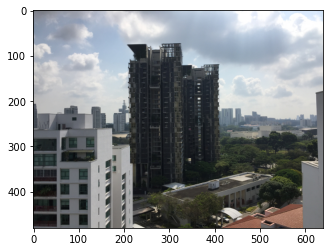

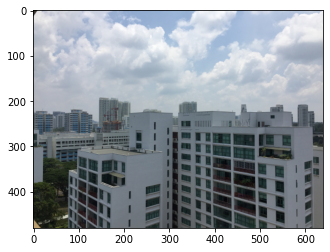

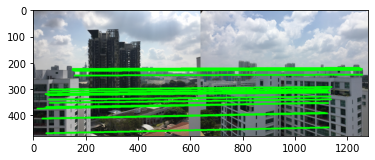

[[ 3.21602416e-01  1.43402226e-02  4.28003201e+02]
 [-3.03406940e-01  8.41923194e-01  3.06438747e+01]
 [-1.35215299e-03 -2.88441504e-05  1.00000000e+00]]
0 2


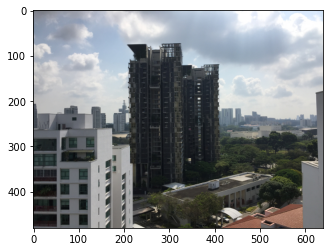

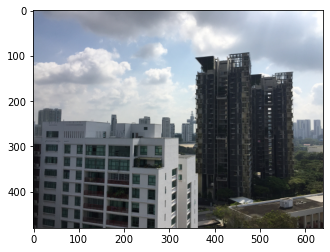

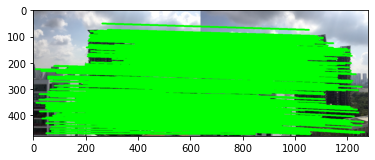

[[ 6.92244404e-01 -4.25945456e-02  1.80702798e+02]
 [-1.06012041e-01  8.45425498e-01  5.18430505e+01]
 [-4.61326392e-04 -7.60343465e-05  1.00000000e+00]]
1 2


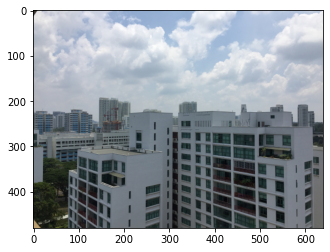

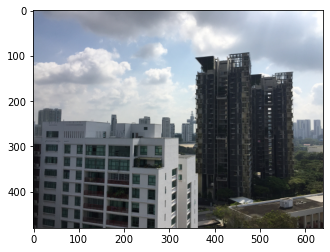

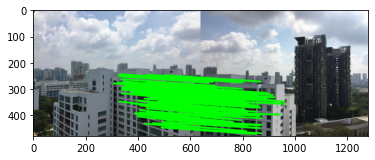

[[ 2.27577686e+00 -1.17376156e-01 -6.68254281e+02]
 [ 5.75334097e-01  1.82682335e+00 -2.06163364e+02]
 [ 2.01603879e-03 -2.12438666e-04  1.00000000e+00]]


In [359]:
import logging
matches= defaultdict(dict)
n_imgs=len(files)
for src in range(n_imgs):
        
        for dst in range(src+1, n_imgs):
            print(src,dst)
            logging.debug(f"Matching {src+1}-{dst+1}")
            im1=plt.imread(files[src])
            #im1=cv2.resize(im1,(320,240))
            im2=plt.imread(files[dst])
            #im2=cv2.resize(im2,(320,240))
            kp1,des1=kp_des(files[src])
            kp2,des2=kp_des(files[dst])
            #cent = np.array([img.shape[1], img.shape[0]]) / 2
            #kp1_c=np.float32([kp.pt - cent for kp in kp1])
            #kp2_c=np.float32([kp.pt - cent for kp in kp2])
            inliers_X1,inliers_X2=best_matches(des1,des2,kp1,kp2,im1,im2)
            #good = flann_matching(des1, des2)
            #match = np.int32([(m.queryIdx, m.trainIdx) for m in good])
            #if len(match) < N_MIN_MATCH:
             #match=(None,None)

#             inliers_X1 = np.int32([kp1_c[m] for m, _ in match])
#             inliers_X1=np.concatenate([inliers_X1,np.ones((inliers_X1.shape[0], 1))],
#                              axis=1)
#             inliers_X2 = np.int32([kp2_c[m] for _, m in match])
#             inliers_X2=np.concatenate([inliers_X2,np.ones((inliers_X2.shape[0], 1))],
#                              axis=1)
            #inliers_X1_idx,inliers_X2_idx=best_matches(des1,des2)
            hom=compute_homography(inliers_X1,inliers_X2)
            print(hom)
            if hom is None:
                continue

            matches[src][dst] = (np.concatenate([inliers_X1, inliers_X2],
                              axis=1), hom,len(inliers_X1))
            matches[dst][src] = (np.concatenate([inliers_X2, inliers_X1],
                              axis=1), np.linalg.inv(hom),len(inliers_X1))

In [363]:
matches[0][1]

(array([[157, 228,   1, 617, 224,   1],
        [ 16, 375,   1, 452, 353,   1],
        [157, 228,   1, 617, 224,   1],
        [ 50, 369,   1, 488, 354,   1],
        [ 56, 324,   1, 493, 314,   1],
        [ 60, 341,   1, 496, 329,   1],
        [ 56, 324,   1, 493, 314,   1],
        [ 50, 469,   1, 490, 447,   1],
        [ 47, 320,   1, 485, 308,   1],
        [150, 228,   1, 608, 224,   1],
        [ 57, 311,   1, 493, 301,   1],
        [ 63, 353,   1, 499, 340,   1],
        [158, 249,   1, 618, 246,   1],
        [151, 224,   1, 608, 220,   1],
        [156, 231,   1, 615, 228,   1],
        [ 66, 302,   1, 501, 293,   1],
        [ 35, 413,   1, 475, 391,   1],
        [ 44, 413,   1, 484, 393,   1]]),
 array([[ 3.21602416e-01,  1.43402226e-02,  4.28003201e+02],
        [-3.03406940e-01,  8.41923194e-01,  3.06438747e+01],
        [-1.35215299e-03, -2.88441504e-05,  1.00000000e+00]]),
 18)

In [366]:
for i in matches.keys():
    for j in matches[i].keys():
        print("Image "+files[i]+" found " + str(matches[i][j][2])+ " with image "+ files[j])


Image im03.jpg found 18 with image im01.jpg
Image im03.jpg found 358 with image im02.jpg
Image im01.jpg found 18 with image im03.jpg
Image im01.jpg found 114 with image im02.jpg
Image im02.jpg found 358 with image im03.jpg
Image im02.jpg found 114 with image im01.jpg


It can be seen that matches are the least between im03.jpg and im01.jpg while it is very between im02.jpg and im01.jpg. We can therefore conclude that image 0 can only be stitched with image 1 while image 2 can only be stitched with image 1

Implementing bundle adjustment for 2 images:
Bundle Adjustment involves the estimation of focal length using which the rotation matrix and intrinsic parameters between images can be computed in order to generate the homography matrix. Coordinates obtained from this newly generated homography matrix and those obtaine from original homography matrix obtained through SVD are compared and their error is minimized accordingly.

The following codes have been referred from 

In [232]:
files=['im02.jpg','im03.jpg']
imgs = [cv2.imread(f) for f in files]
full_img_sizes=[]
images=[]
for f in files:
    full_img = cv2.imread(f)
        
    if full_img is None:
        print("Cannot read image ", name)
        exit()
    full_img_sizes.append((full_img.shape[1],full_img.shape[0]))
    if work_megapix < 0:
        img = full_img
        work_scale = 1
        is_work_scale_set = True
    else:
        if is_work_scale_set is False:
            work_scale = min(1.0, np.sqrt(work_megapix * 1e6 / (full_img.shape[0]*full_img.shape[1])))
            is_work_scale_set = True
        img = cv2.resize(src=full_img, dsize=None, fx=work_scale, fy=work_scale, interpolation=cv2.INTER_LINEAR_EXACT)
    if is_seam_scale_set is False:
        seam_scale = min(1.0, np.sqrt(seam_megapix * 1e6 / (full_img.shape[0]*full_img.shape[1])))
        seam_work_aspect = seam_scale / work_scale
                     #Stitched area size/registration
        is_seam_scale_set = True
#     imgFea= cv2.detail.computeImageFeatures2(finder,img)
#              #Feature extraction of a single picture, finder is the feature extractor object
#     features.append(imgFea)
             #Adjust the picture size according to the above and save it to the images picture list
    img = cv2.resize(src=full_img, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv2.INTER_LINEAR_EXACT)
    images.append(img)

In [234]:
seam_scale

0.570544330734548

Finding the best matches for image 2 and image 3:

3
0
1
6
5
0
144
0
3
0
6
4
13
158
2
158
6
2
58
3
3
87
0
80
1
2
12
149
4
0
0
6
0
1
0
13
68
103
1
3
8
0
124
0
5
0
0
1
7
21
4
0
51
1
119
166
155
0
0
1
2
1
2
31
155
158
4
3
0
131
8
42
0
97
143
1
0
152
15
124
0
3
6
6
2
120
2
3
5
108
147
2
123
0
164
164
1
6
1
1
40
0
0
63
0
1
2
44
2
1
5
2
24
0
1
1
114
4
3
147
137
14
1
0
4
163
0
4
6
2
106
7
140
139
7
2
1
152
130
0
0
0
5
10
0
42
0
2
60
7
64
1
0
0
41
8
2
0
165
2
137
132
2
156
1
1
3
162
155
77
2
7
16
0
2
3
4
6
1
132
16
1
110
162
15
0
1
1
8
56
0
1
91
1
114
3
0
139
5
0


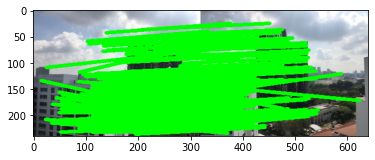

In [4]:
kpts, descs = [], []
im1=plt.imread('im02.jpg')
im1=cv2.resize(im1,(320,240))
img=im1.copy()
sift1 = cv2.SIFT_create()
gray_im1= cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)

kp1, des1 = sift1.detectAndCompute(im1,None)
img=cv2.drawKeypoints(im1,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


im2=plt.imread('im03.jpg')
im2=cv2.resize(im2,(320,240))
img1=im2.copy()
sift2 = cv2.SIFT_create()
gray_im2= cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

kp2, des2 = sift2.detectAndCompute(im2,None)
img1=cv2.drawKeypoints(im2,kp2,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img)

plt.imshow(img1)

#des1.shape

#des2.shape

threshold=1.5

best_match=1
(des1[0,:]-des2[0,:]).shape

threshold=1.5
matches=[]
scores=[]
dist=[]
for i in range(0,des1.shape[0]):
    #print(i)
    closest_distance=1e10
    second_closest_dist=1e10
    best_match=None
    dist_temp=[]
    for j in range(0,des2.shape[0]):
        
        
        
        d = des1[i,:] - des2[j,:]
        
        squared_dist = np.sum(d**2)
        dist_temp.append(squared_dist)
        #print(squared_dist)
        if squared_dist<closest_distance:
#             print(j)
#             print(closest_distance)
#             print(squared_dist)
            
            second_closest_dist=closest_distance
            closest_distance=squared_dist
            best_match=j
        elif squared_dist<second_closest_dist:
            second_closest_dist=squared_dist
    if (threshold * closest_distance < second_closest_dist) and (best_match != None):
        #print(i)
        #print(j)
        matches.append([i,best_match])
        scores.append(closest_distance)
    dist.append(dist_temp)

#min(dist[0])

#dist[0][1224]

# matches=[]
# scores=[]

#matches

#matches1=matches.sort(reverse=True)
#matches1

# img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches1[:50], im2, flags=2)
# plt.imshow(img3),plt.show()

#matches

ind=np.argsort(np.array(scores))
matches1=[]
matches_img1=[]
matches_img2=[]
for i in ind:
    matches1.append(matches[i])
    matches_img1.append(matches[i][0])
    matches_img2.append(matches[i][1])

#matches1

# img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches1[:50], im2, flags=2)
# plt.imshow(img3),plt.show()

# plt.imshow(im2)
#im2.shape

#kp1[matches1[0][0]].pt[0]

x1=[]
y1=[]
x2=[]
y2=[]
for i in range(0,len(matches1)):
    x1.append(kp1[matches1[i][0]].pt[0])
    y1.append(kp1[matches1[i][0]].pt[1])
    x2.append(kp2[matches1[i][1]].pt[0]+im2.shape[1])
    y2.append(kp2[matches1[i][1]].pt[1])
    

coordinates_im1=[]
coordinates_im2=[]
for i in range(0,len(matches1)):
    coordinates_im1.append([int(kp1[matches1[i][0]].pt[0]),int(kp1[matches1[i][0]].pt[1])])
    coordinates_im2.append([int(kp2[matches1[i][1]].pt[0]+im2.shape[1]),int(kp2[matches1[i][1]].pt[1])])
#     x1.append(kp1[matches1[i][0]].pt[0])
#     y1.append(kp1[matches1[i][0]].pt[1])
#     x2.append(kp2[matches1[i][1]].pt[0]+im2.shape[1])
#     y2.append(kp2[matches1[i][1]].pt[1])

x2

#coordinates_im1[0]

im_concat = cv2.hconcat([im1, im2])
image=im_concat.copy()
for i in range(0,len(matches1)):
    image = cv2.line(im_concat,coordinates_im1[i],coordinates_im2[i],(0, 255, 0),thickness=5)

plt.imshow(image)


#matches1[k[0]][1]


coordinates_im1_hm=[]
coordinates_im2_hm=[]
for i in range(0,len(matches1)):
    coordinates_im1_hm.append([int(kp1[matches1[i][0]].pt[0]),int(kp1[matches1[i][0]].pt[1]),1])
    coordinates_im2_hm.append([int(kp2[matches1[i][1]].pt[0]),int(kp2[matches1[i][1]].pt[1]),1])

import random 
#dist=[]
iterations=200
n=5
inliers_max=0
for t in range(0,iterations):
    rand_indices=[]
    points=[]
    coordinates_1=[]
    coordinates_2=[]
    for i in range(0,5):
        rand_index=random.sample(range(0, len(matches1)), 1)
        if rand_index not in rand_indices:
            rand_indices.append(rand_index)
            
    for k in rand_indices:
        coordinates_1.append(np.array(kp1[matches1[k[0]][0]].pt,dtype=int))
        coordinates_2.append(np.array(kp2[matches1[k[0]][1]].pt,dtype=int))
    coordinates_1_hm=[]
    coordinates_2_hm=[]
    A = []
    b = []
    for i in range(len(coordinates_1)):
        s_x, s_y = coordinates_1[i]
        coordinates_1_hm.append([s_x,s_y,1])
        d_x, d_y = coordinates_2[i]
        coordinates_2_hm.append([d_x,d_y,1])
        A.append([s_x, s_y, 1, 0, 0, 0, -(d_x)*(s_x), -(d_x)*(s_y),-d_x])
        A.append([0, 0, 0, s_x, s_y, 1, -(d_y)*(s_x), -(d_y)*(s_y),-d_y])
        b += [d_x, d_y]
    A = np.array(A)
    #h = np.linalg.lstsq(A, b,rcond=-1)[0]
    #h = np.concatenate((h, [1]), axis=-1)

    import scipy.linalg as linalg
    A = np.array(A)
    U, Sigma, V_transpose = linalg.svd(A)

    H = np.reshape(V_transpose[-1], (3,3))
    coordinates_1_transform=np.dot(H,np.array(coordinates_im1_hm).T)
    dx=(np.array(coordinates_1_transform)[0]/np.array(coordinates_1_transform)[2])-(np.array(coordinates_im2_hm).T[0]/np.array(coordinates_im2_hm).T[2])
    dy=(np.array(coordinates_1_transform)[1]/np.array(coordinates_1_transform)[2])-(np.array(coordinates_im2_hm).T[1]/np.array(coordinates_im2_hm).T[2])
    inliers_f=np.array(dx**2+dy**2<3**2,dtype=int)
    #dist.append(dx**2+dy**2)
    inliers_num = np.sum(inliers_f)
    #if inliers_num==5:
        #print(dx**2+dy**2)
    print(inliers_num)
    if inliers_num > inliers_max:
        inliers_max = inliers_num
        inliers_indices=[index for index in range(len(inliers_f)) if inliers_f[index] ==1]
        for inlier_ind in inliers_indices:
            inliers_X1 = np.array(coordinates_im1_hm)[inliers_indices]
            inliers_X2 = np.array(coordinates_im2_hm)[inliers_indices]
            best_X1 = np.array(coordinates_1) # the X1 keypoints that matches best
            best_X2 = np.array(coordinates_2) # the X2 keypoints that matches best
            best_H12 = H;         # the transformation between best X1 and X2
    

Obtaining homography matrix through SVD:

In [19]:
A = []
b = []
coordinates_src=[]
coordinates_dst=[]
for i in range(len(inliers_X1)):
    s_x, s_y = inliers_X1[i][0:2]
    coordinates_src.append(inliers_X1[i][0:2])
   # coordinates_1_hm.append([s_x,s_y,1])
    d_x, d_y = inliers_X2[i][0:2]
    coordinates_dst.append(inliers_X2[i][0:2])
    #coordinates_2_hm.append([d_x,d_y,1])
    A.append([s_x, s_y, 1, 0, 0, 0, -(d_x)*(s_x), -(d_x)*(s_y),-d_x])
    A.append([0, 0, 0, s_x, s_y, 1, -(d_y)*(s_x), -(d_y)*(s_y),-d_y])
    b += [d_x, d_y]
A = np.array(A)
#h = np.linalg.lstsq(A, b,rcond=-1)[0]
#h = np.concatenate((h, [1]), axis=-1)

import scipy.linalg as linalg
A = np.array(A)
U, Sigma, V_transpose = linalg.svd(A)

H = np.reshape(V_transpose[-1], (3,3))

In [5]:
kpts.append(np.float32([kp.pt for kp in kp1]))
descs.append(des1)
kpts.append(np.float32([kp.pt for kp in kp2]))
descs.append(des2)

Adding the match points and homography matrix into a dictionary:

In [8]:
from collections import defaultdict
matches, n_imgs = defaultdict(dict), 2

In [20]:
hom, mask = cv2.findHomography(np.array(coordinates_src), np.array(coordinates_dst), cv2.RANSAC)
mask = (mask != 0).squeeze() 

In [21]:
hom1=hom

In [15]:
inliers_X1_mask=inliers_X1[mask, :]
inliers_X2_mask=inliers_X1[mask,:]

In [17]:
matches[0][1] = ([inliers_X1_mask,inliers_X2_mask], hom)
matches[1][0] =([inliers_X2_mask,inliers_X1_mask], np.linalg.inv(hom))

In [18]:
matches

defaultdict(dict,
            {0: {1: ([array([[172, 215,   1],
                       [178, 205,   1],
                       [172, 204,   1],
                       [172, 226,   1],
                       [288, 120,   1],
                       [178, 216,   1],
                       [155, 177,   1],
                       [261, 148,   1],
                       [123, 165,   1],
                       [172, 193,   1],
                       [184, 133,   1],
                       [ 94, 195,   1],
                       [182,  95,   1],
                       [144, 184,   1],
                       [284,  92,   1],
                       [184, 144,   1],
                       [155, 177,   1],
                       [102, 209,   1],
                       [121, 203,   1],
                       [155, 191,   1],
                       [234, 204,   1],
                       [244, 182,   1],
                       [223, 204,   1],
                       [232, 116,   1],
                

Focal length estimation:

In [23]:
def _focal(v1, v2, d1, d2):
    """Get focal from two squared estimates."""
    if v1 < v2:
        v1, v2 = v2, v1
    if v1 > 0 and v2 > 0:
        return np.sqrt(v1 if abs(d1) > abs(d2) else v2)
    elif v1 > 0:
        return np.sqrt(v1)
    return 0

In [30]:
hom = np.linalg.inv(hom1).ravel()
#hom = hom1.ravel()
d1, d2 = hom[6]*hom[7], (hom[7] - hom[6])*(hom[7] + hom[6])
v1 = -(hom[0]*hom[1] + hom[3]*hom[4]) / d1
v2 = (hom[0]*hom[0] + hom[3]*hom[3] - hom[1]*hom[1] - hom[4]*hom[4]) / d2
f1 = _focal(v1, v2, d1, d2)

d1 = hom[0]*hom[3] + hom[1]*hom[4]
d2 = hom[0]*hom[0] + hom[1]*hom[1] - hom[3]*hom[3] - hom[4]*hom[4]
v1, v2 = -hom[2]*hom[5] / d1, (hom[5]*hom[5] - hom[2]*hom[2]) / d2
f0 = _focal(v1, v2, d1, d2)

#return np.sqrt(f0*f1)

In [38]:
f1
focal=np.sqrt(f0*f1)

Defining the intrinsics matrix:

In [40]:
center=(0,0)
if not isinstance(focal, (list, tuple)):
        focal = (focal,)*2
intr=np.array(
        [[focal[0], 0, center[0]], [0, focal[0], center[1]], [0, 0, 1]])

In [33]:
from dataclasses import dataclass

In [34]:
@dataclass
class Image:
    """Patch with all the informations for stitching."""

    img: np.ndarray
    rot: np.ndarray
    intr: np.ndarray
    range: tuple = (np.zeros(2), np.zeros(2))

    def hom(self):
        """Homography from pixel to normalized coordinates."""
        return self.rot.T.dot(np.linalg.inv(self.intr))

    def proj(self):
        """Return camera projection transform."""
        return self.intr.dot(self.rot)


In [75]:
src=0
cameras = [None] * 2
cameras[src] = Image(None, np.eye(3), intr)

In [42]:
cameras[0]

Image(img=None, rot=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), intr=array([[272.35930004,   0.        ,   0.        ],
       [  0.        , 272.35930004,   0.        ],
       [  0.        ,   0.        ,   1.        ]]), range=(array([0., 0.]), array([0., 0.])))

In [44]:
import heapq
qq_ = [(-len(inliers_X1), 0, 1) ]
heapq.heapify(qq_)


The rotational matrix and homography between 2 images is estimated using the functions below:

In [52]:
match_pts=np.concatenate([inliers_X1, inliers_X2],
                              axis=1)


In [47]:
def to_rotation(rot):
    """Find the closest rotation in the Frobenious norm."""
    uu_, _, vv_ = np.linalg.svd(rot)
    rot = uu_.dot(vv_)
    if np.linalg.det(rot) < 0:
        rot *= -1   # no reflections
    return rot

In [53]:
def _hom_to_from(cm1, cm2):
    """Homography between two cameras."""
    return (cm1.intr.dot(cm1.rot)).dot(cm2.rot.T.dot(np.linalg.inv(cm2.intr)))

In [54]:
def get_diff(cam1, cam2, match):
    """Get the residual for a given match."""
    hom = _hom_to_from(cam1, cam2)
    trans = hom.dot(match[:, 3:6].T)
    return (match[:, :3].T - trans / trans[[-1], :])[:-1].ravel()


In [78]:
PARAMS_PER_CAMERA = 6
TERMS_PER_MATCH = 2
# Levenberg–Marquardt parameters
LM_LAMBDA = 5         # regularization strenght
LM_MAX_ITER = 100     # maximum number of iterations
# remove matches with this initial error - they are likely mismatches
MIN_MATCH_ERROR = 150

In [126]:
src=0
cameras = [None] * 2
cameras[src] = Image(None, np.eye(3), intr)
qq_ = [(-len(inliers_X1), 0, 1) ]
heapq.heapify(qq_)
matches2=[]
while True:
        try:
            _, src, dst = heapq.heappop(qq_)
        except IndexError:
            break
        if cameras[1] is not None:  # already estimated
            continue

        hom = hom1
        rot = to_rotation(np.linalg.inv(intr).dot(hom.dot(intr)))
        rot = rot.dot(cameras[0].rot)

        # add camera and all its valid matches
        camera=Image(None, rot, intr)
        cameras[1] = Image(None, rot, intr)
        idx=1
        for new, cam in enumerate(cameras):
#             if cam is None or new not in matches[idx]:
#                 continue
                
            cm1=camera
            cm2=cam
            match = match_pts
            hom2=(cm1.intr.dot(cm1.rot)).dot(cm2.rot.T.dot(np.linalg.inv(cm2.intr)))
            trans = hom2.dot(match_pts[:, 3:6].T)
            diff=(match_pts[:, :3].T - trans / trans[[-1], :])[:-1].ravel()
            loss1=np.sqrt(np.mean(np.square(diff)))
            matches2.append((new, 1, match_pts))
            print(loss)
            if loss1 > MIN_MATCH_ERROR:
                continue
            matches2.append((new, idx, match))
        cameras1=optimize(cameras,matches2)

#         iba.add(dst, Image(None, rot, intr), matches)

#         for new in matches[dst].keys():
#             heapq.heappush(qq_, (-matches[dst][new][2], dst, new))


55.35003618810099
55.35003618810099
entered loop
[175.63937968 176.26475491 175.25640604 ...  11.          18.
   2.        ]
[-57.86678199 -61.44823483 -57.20191324 ...  11.          18.
   2.        ]
61.163129869865756 102.02250849664262
[ -9.89074747 -10.91826434  -9.58478807 ...  11.          18.
   2.        ]
40.295085788782416 61.163129869865756
[-2.40727309 -2.49192979 -2.08830107 ... 11.         18.
  2.        ]
39.267833081010515 40.295085788782416
[-4.28031312 -4.26179223 -4.01847301 ... 11.         18.
  2.        ]
39.210982674382755 39.267833081010515
[-4.51599627 -4.52622194 -4.332099   ... 11.         18.
  2.        ]
39.202640884522715 39.210982674382755
[-4.52882373 -4.56904142 -4.39479738 ... 11.         18.
  2.        ]
39.2003624268046 39.202640884522715
[-4.52035983 -4.58449056 -4.42036568 ... 11.         18.
  2.        ]
39.199795867339795 39.2003624268046
[-4.53980978 -4.59695161 -4.42764582 ... 11.         18.
  2.        ]
39.20029092259835 39.20036242680

In [114]:
cameras1

[Image(img=None, rot=array([[ 0.7377969 , -0.13476341, -0.66143371],
        [ 0.05313383,  0.9884227 , -0.1421174 ],
        [ 0.67292832,  0.06970927,  0.73641571]]), intr=array([[355.24925229,   0.        , -68.54808743],
        [  0.        , 355.24925229, -42.91280168],
        [  0.        ,   0.        ,   1.        ]]), range=(array([0., 0.]), array([0., 0.]))),
 Image(img=None, rot=array([[ 0.80761985, -0.11904903, -0.57756169],
        [ 0.05220016,  0.98999801, -0.13106897],
        [ 0.58738856,  0.07570508,  0.80575643]]), intr=array([[320.7703134 ,   0.        , -24.49164578],
        [  0.        , 320.7703134 , -26.62805755],
        [  0.        ,   0.        ,   1.        ]]), range=(array([0., 0.]), array([0., 0.])))]

In [122]:
cameras = cameras1
cameras

[Image(img=None, rot=array([[ 0.7377969 , -0.13476341, -0.66143371],
        [ 0.05313383,  0.9884227 , -0.1421174 ],
        [ 0.67292832,  0.06970927,  0.73641571]]), intr=array([[355.24925229,   0.        , -68.54808743],
        [  0.        , 355.24925229, -42.91280168],
        [  0.        ,   0.        ,   1.        ]]), range=(array([0., 0.]), array([0., 0.]))),
 Image(img=None, rot=array([[ 0.80761985, -0.11904903, -0.57756169],
        [ 0.05220016,  0.98999801, -0.13106897],
        [ 0.58738856,  0.07570508,  0.80575643]]), intr=array([[320.7703134 ,   0.        , -24.49164578],
        [  0.        , 320.7703134 , -26.62805755],
        [  0.        ,   0.        ,   1.        ]]), range=(array([0., 0.]), array([0., 0.])))]

[Image(img=array([[[0.60554254, 0.5179483 , 0.4874808 , 0.04      ],
        [0.5903088 , 0.52175677, 0.47986388, 0.0396875 ],
        [0.60554254, 0.5255652 , 0.49509767, 0.039375  ],
        ...,
        [0.9711531 , 0.9711531 , 0.96734464, 0.0390625 ],
        [0.94830245, 0.93306863, 0.9292602 , 0.039375  ],
        [0.9559193 , 0.910218  , 0.89498425, 0.0396875 ]],

       [[0.6131594 , 0.52937365, 0.4874808 , 0.03958333],
        [0.6017341 , 0.5255652 , 0.48367232, 0.03927409],
        [0.6017341 , 0.52937365, 0.4989061 , 0.03896485],
        ...,
        [0.9711531 , 0.9711531 , 0.9711531 , 0.0386556 ],
        [0.9559193 , 0.94830245, 0.94449395, 0.03896485],
        [0.9521109 , 0.90640956, 0.8987927 , 0.03927409]],

       [[0.6131594 , 0.52937365, 0.4874808 , 0.03916667],
        [0.6131594 , 0.5255652 , 0.49509767, 0.03886068],
        [0.60554254, 0.5255652 , 0.49509767, 0.03855469],
        ...,
        [0.9711531 , 0.9711531 , 0.9711531 , 0.0382487 ],
        [0.9711531

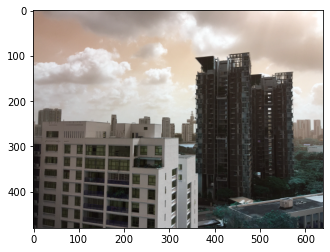

1


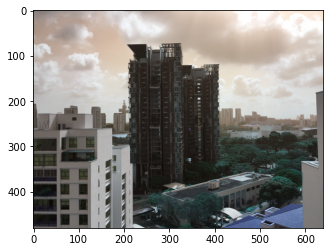

[Image(img=array([[[159, 136, 128],
        [155, 137, 126],
        [159, 138, 130],
        ...,
        [255, 255, 254],
        [249, 245, 244],
        [251, 239, 235]],

       [[161, 139, 128],
        [158, 138, 127],
        [158, 139, 131],
        ...,
        [255, 255, 255],
        [251, 249, 248],
        [250, 238, 236]],

       [[161, 139, 128],
        [161, 138, 130],
        [159, 138, 130],
        ...,
        [255, 255, 255],
        [255, 254, 253],
        [249, 243, 238]],

       ...,

       [[ 19,  20,  18],
        [ 23,  18,  19],
        [ 28,  23,  25],
        ...,
        [ 20,  19,  29],
        [ 19,  18,  27],
        [ 22,  18,  29]],

       [[ 21,  21,  21],
        [ 23,  21,  21],
        [ 27,  25,  25],
        ...,
        [ 23,  24,  28],
        [ 20,  21,  25],
        [ 23,  23,  29]],

       [[ 18,  20,  20],
        [ 20,  18,  18],
        [ 25,  23,  23],
        ...,
        [ 23,  23,  29],
        [ 20,  23,  28],
        [ 20,

In [299]:
files=['im02.jpg','im03.jpg']
imgs = [cv2.imread(f) for f in files]
cameras2 = cameras1.copy()
print(cameras2)
for idx, img in enumerate(imgs):
    print(idx)
    if cameras2[idx] is not None:
        cameras2[idx].img = img
        plt.imshow(cameras2[idx].img)
        plt.show()

cameras2 = [c for c in cameras2 if c is not None]
print(cameras2)
use_straighten=False
if use_straighten:
    rots = straighten([c.rot for c in cameras2 if c is not None])
    for cam, rot in zip(cameras2, rots):
        cam.rot = rot

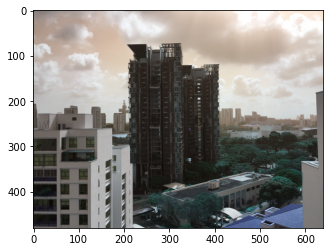

In [300]:
plt.imshow(cameras2[1].img)

In [236]:
focal

(272.3593000405166, 272.3593000405166)

In [321]:
warper = cv2.PyRotationWarper('cylindrical',focal[0]*seam_work_aspect)


In [322]:
np.float32(cameras3[idx].rot)

array([[ 0.80761987, -0.11904903, -0.5775617 ],
       [ 0.05220016,  0.98999804, -0.13106896],
       [ 0.5873886 ,  0.07570508,  0.80575645]], dtype=float32)

In [323]:
corners=[]
mask=[]
masks_warped=[]
images_warped=[]
sizes=[]
masks=[]
num_images=2
for i in range(0,num_images):
    um=cv2.UMat(255*np.ones((images[i].shape[0],images[i].shape[1]),np.uint8))
    masks.append(um)
     #Handle the distortion caused by camera rotation
#warper = cv.PyRotationWarper(warp_type,warped_image_scale*seam_work_aspect) # warper peut etre nullptr?
for idx in range(0,num_images):
    K = cameras3[idx].intr.astype(np.float32)#Camera internal parameters
    swa = seam_work_aspect
    K[0,0] *= swa
    K[0,2] *= swa
    K[1,1] *= swa
    K[1,2] *= swa
    corner,image_wp =warper.warp(images[idx],K,np.float32(cameras3[idx].rot),cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    corners.append(corner)
    sizes.append((image_wp.shape[1],image_wp.shape[0]))
    images_warped.append(image_wp)

    p,mask_wp =warper.warp(masks[idx],K,np.float32(cameras3[idx].rot),cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)#Linear difference, continuous boundary processing
    masks_warped.append(mask_wp.get())


In [324]:
images_warped_f=[]
for img in images_warped:
    #For the projected image, single precision storage
    imgf=img.astype(np.float32)
    images_warped_f.append(imgf)

In [325]:
seam_find_type = "gc_color"

In [326]:
if seam_find_type == "no":
        seam_finder = cv2.detail.SeamFinder_createDefault(cv2.detail.SeamFinder_NO)
elif seam_find_type == "voronoi":
    seam_finder = cv2.detail.SeamFinder_createDefault(cv2.detail.SeamFinder_VORONOI_SEAM);
elif seam_find_type == "gc_color":
    seam_finder = cv2.detail_GraphCutSeamFinder("COST_COLOR")
elif seam_find_type == "gc_colorgrad":
    seam_finder = cv2.detail_GraphCutSeamFinder("COST_COLOR_GRAD")
elif seam_find_type == "dp_color":
    seam_finder = cv2.detail_DpSeamFinder("COLOR")
elif seam_find_type == "dp_colorgrad":
    seam_finder = cv2.detail_DpSeamFinder("COLOR_GRAD")
if seam_finder is None:
    print("Can't create the following seam finder ",seam_find_type)
    exit()
seam_finder.find(images_warped_f, corners,masks_warped )

In [327]:
blend_type = "no"
is_compose_scale_set=False
compose_megapix=-1
timelapse=False
blend_strength=5

In [328]:
compose_scale=1
corners=[]
sizes=[]
images_warped=[]
images_warped_f=[]
masks=[]
blender= None
timelapser=None
compose_work_aspect=1
warped_image_scale=focal[0]
for idx,name in enumerate(files): # https://github.com/opencv2/opencv2/blob/master/samples/cpp/stitching_detailed.cpp#L725 ?
    full_img  = cv2.imread(name)
    if not is_compose_scale_set:
        if compose_megapix > 0:
                     #exp is 2.718; e is 10^
            compose_scale = min(1.0, np.sqrt(compose_megapix * 1e6 / (full_img.shape[0]*full_img.shape[1])))
        is_compose_scale_set = True;
        compose_work_aspect = compose_scale / work_scale;
        warped_image_scale *= compose_work_aspect
        warper =  cv2.PyRotationWarper('cylindrical',warped_image_scale)
        for i in range(0,len(files)):
#                 cameras3[i].focal *= compose_work_aspect
#                 cameras3[i].ppx *= compose_work_aspect
#                 cameras3[i].ppy *= compose_work_aspect
            sz = (full_img_sizes[i][0] * compose_scale,full_img_sizes[i][1]* compose_scale)
            K = cameras3[i].intr.astype(np.float32)
            roi = warper.warpRoi(sz, K, np.float32(cameras3[i].rot));
                             #Stitched area get
            corners.append(roi[0:2])
            sizes.append(roi[2:4])
    if abs(compose_scale - 1) > 1e-1:
        img =cv2.resize(src=full_img, dsize=None, fx=compose_scale, fy=compose_scale, interpolation=cv2.INTER_LINEAR_EXACT)
    else:
        img = full_img;
    img_size = (img.shape[1],img.shape[0]);
    K=cameras3[idx].intr.astype(np.float32)
    corner,image_warped =warper.warp(img,K,np.float32(cameras3[idx].rot),cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    mask =255*np.ones((img.shape[0],img.shape[1]),np.uint8)
    p,mask_warped =warper.warp(mask,K,np.float32(cameras3[idx].rot),cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)
             #Block gain compensation
    #compensator.apply(idx,corners[idx],image_warped,mask_warped)
    image_warped_s = image_warped.astype(np.int16)
    image_warped=[]
             #Bloat
    dilated_mask = cv2.dilate(masks_warped[idx],None)
    seam_mask = cv2.resize(dilated_mask,(mask_warped.shape[1],mask_warped.shape[0]),0,0,cv2.INTER_LINEAR_EXACT)
    mask_warped = cv2.bitwise_and(seam_mask,mask_warped)#Binary AND operation, 1&1 == 1, 1&0 == 0
    if blender==None and not timelapse:
        blender = cv2.detail.Blender_createDefault(cv2.detail.Blender_NO)
        dst_sz = cv2.detail.resultRoi(corners=corners,sizes=sizes)
        blend_width = np.sqrt(dst_sz[2]*dst_sz[3]) * blend_strength / 100
        if blend_width < 1:
            blender = cv2.detail.Blender_createDefault(cv2.detail.Blender_NO)
        elif blend_type == "multiband":
            blender = cv2.detail_MultiBandBlender()
            blender.setNumBands((np.log(blend_width)/np.log(2.) - 1.).astype(np.int))
        elif blend_type == "feather":#  Fusion
            blender = cv2.detail_FeatherBlender()
            blender.setSharpness(1./blend_width)
        blender.prepare(dst_sz)
    elif timelapser==None  and timelapse:
        timelapser = cv2.detail.Timelapser_createDefault(timelapse_type)
        timelapser.initialize(corners, sizes)
    if timelapse:
             #Delay processing
        matones=np.ones((image_warped_s.shape[0],image_warped_s.shape[1]), np.uint8)
        timelapser.process(image_warped_s, matones, corners[idx])
        pos_s = img_names[idx].rfind("/");
        if pos_s == -1:
            fixedFileName = "fixed_" + img_names[idx];
        else:
            fixedFileName = img_names[idx][:pos_s + 1 ]+"fixed_" + img_names[idx][pos_s + 1: ]
        cv2.imwrite(fixedFileName, timelapser.getDst())
    else:
        blender.feed(cv2.UMat(image_warped_s), mask_warped, corners[idx])



In [329]:
if not timelapse:
    result=None
    result_mask=None
    result,result_mask = blender.blend(result,result_mask)
    result_name='result.jpg'
    cv2.imwrite(result_name,result)
    zoomx = 600.0 / result.shape[1]
    dst=cv2.normalize(src=result,dst=None,alpha=255.,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
    dst=cv2.resize(dst,dsize=None,fx=zoomx,fy=zoomx)
    #plt.imshow(result_name,dst)
    #cv2.waitKey()

print('Done')

Done


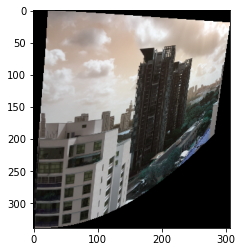

In [331]:
plt.imshow(result)

In [ ]:
compose_scale=1
for i in range(0,len(img_names)):
#                 cameras[i].focal *= compose_work_aspect
#                 cameras[i].ppx *= compose_work_aspect
#                 cameras[i].ppy *= compose_work_aspect
    sz = (full_img_sizes[i][0] * compose_scale,full_img_sizes[i][1]* compose_scale)
    K = cameras[i].K().astype(np.float32)
    roi = warper.warpRoi(sz, K, cameras[i].R);
                     #Stitched area get
    corners.append(roi[0:2])
    sizes.append(roi[2:4])

In [93]:

def straighten(rots):
    """Global rotation to have the x axis on the same plane."""
    cov = np.cov(np.stack([rot[0] for rot in rots], axis=-1))
    _, _, vv_ = np.linalg.svd(cov)
    v_y = vv_[2]
    v_z = np.sum(np.stack([rot[2] for rot in rots], axis=0), axis=0)
    v_x = np.cross(v_y, v_z)
    v_x /= np.linalg.norm(v_x)
    v_z = np.cross(v_x, v_y)

    # ensure that the vertical versor points up
    sign = np.sum([v_x.dot(rot[0]) for rot in rots])
    if sign < 0:
        v_x, v_y = -v_x, -v_y

    rot_g = np.stack([v_x, v_y, v_z], axis=-1)
    return [rot.dot(rot_g) for rot in rots]


In [88]:
import logging


In [90]:
def optimize(cameras,matches):
      
        """Refine the camera parameters."""
        idx = [i for i, c in enumerate(cameras) if c is not None]
        print("entered loop")
        errs = residuals(cameras, matches)
        print(errs)
        best_err = np.sqrt(np.mean(np.square(errs)))
        logging.debug(f"Optimizing {len(idx)} cameras")
        logging.debug(f"Initial error: {best_err}")

        n_not_improved = 0   # exit loop if the loss doesn't improve
        for it_ in range(LM_MAX_ITER):
            # Levenberg–Marquardt iteration
            jac, jac_t_jac = _jacobian_symbolic(cameras, matches)
            bb_ = jac.T.dot(errs)
            jac_t_jac += np.eye(jac.shape[1]) * LM_LAMBDA

            params = np.stack([camera_to_params(cameras[i]) for i in idx])
            delta = np.linalg.solve(jac_t_jac, bb_).reshape(params.shape)
            params -= delta

            # update cameras only if the result improves
            cams = cameras.copy()
            for ind, param in zip(idx, params):
                cams[ind] = params_to_camera(param)

            errs = residuals(cams, matches)
            print(errs)
            err = np.sqrt(np.mean(np.square(errs)))
            print(err,best_err)
            if err < best_err - 1e-3:
                best_err = err
                cameras = cams
            else:
                n_not_improved += 1
                if n_not_improved > 5:
                    break
            logging.debug(f"It #{it_} error: {err}")
        logging.debug(f"Final error: {best_err}")
        return cameras

In [62]:
def _hom_to_from(cm1, cm2):
    """Homography between two cameras."""
    return (cm1.intr.dot(cm1.rot)).dot(cm2.rot.T.dot(np.linalg.inv(cm2.intr)))


def _focal(v1, v2, d1, d2):
    """Get focal from two squared estimates."""
    if v1 < v2:
        v1, v2 = v2, v1
    if v1 > 0 and v2 > 0:
        return np.sqrt(v1 if abs(d1) > abs(d2) else v2)
    elif v1 > 0:
        return np.sqrt(v1)
    return 0


def _get_focal(hom):
    """Run on the homography and its inverse to get a valid estimate."""
    hom = hom.ravel()

    d1, d2 = hom[6]*hom[7], (hom[7] - hom[6])*(hom[7] + hom[6])
    v1 = -(hom[0]*hom[1] + hom[3]*hom[4]) / d1
    v2 = (hom[0]*hom[0] + hom[3]*hom[3] - hom[1]*hom[1] - hom[4]*hom[4]) / d2
    f1 = _focal(v1, v2, d1, d2)

    d1 = hom[0]*hom[3] + hom[1]*hom[4]
    d2 = hom[0]*hom[0] + hom[1]*hom[1] - hom[3]*hom[3] - hom[4]*hom[4]
    v1, v2 = -hom[2]*hom[5] / d1, (hom[5]*hom[5] - hom[2]*hom[2]) / d2
    f0 = _focal(v1, v2, d1, d2)

    return np.sqrt(f0*f1)


def get_focal(hom):
    """Estimate the focal lenght from the homography [1].

    References
    ----------
    [1] Szeliski, Richard, and Heung-Yeung Shum. "Creating full view panoramic
    image mosaics and environment maps." Proceedings of the 24th annual
    conference on Computer graphics and interactive techniques. 1997.
    """
    f_ = _get_focal(hom)
    return f_ if f_ else _get_focal(np.linalg.inv(hom))


def intrinsics(focal, center=(0, 0)):
    """Intrinsic matrix from focal."""
    if not isinstance(focal, (list, tuple)):
        focal = (focal,)*2
    return np.array(
        [[focal[0], 0, center[0]], [0, focal[0], center[1]], [0, 0, 1]])


def _cross_mat(vec):
    """Skew symm. matrix for cross product."""
    return np.array(
        [[0, -vec[2], vec[1]], [vec[2], 0, -vec[0]], [-vec[1], vec[0], 0]])


def rotation_to_mat(rad=np.random.randn(3)):
    """Create a rotation matrices from the exponential representation."""
    ang = np.linalg.norm(rad)
    cross = _cross_mat(rad / ang if ang else rad)

    return np.eye(3) + cross*np.sin(ang) + (1-np.cos(ang))*cross.dot(cross)


def mat_to_angle(rot):
    """Exponential representation from rotation matrix."""
    rad = np.array(
        [rot[2, 1]-rot[1, 2], rot[0, 2]-rot[2, 0], rot[1, 0]-rot[0, 1]])
    mod = np.linalg.norm(rad)

    if mod < 1e-7:
        rad = np.zeros(3)
    else:
        theta = np.arccos(np.clip((np.trace(rot)-1) / 2, -1, 1))
        rad *= (theta / mod)
    return rad


def to_rotation(rot):
    """Find the closest rotation in the Frobenious norm."""
    uu_, _, vv_ = np.linalg.svd(rot)
    rot = uu_.dot(vv_)
    if np.linalg.det(rot) < 0:
        rot *= -1   # no reflections
    return rot


#
# Bundle adjustment
#

def params_to_camera(params):
    """Convert the camera parameters to rotation / calibration matrix."""
    foc, x_c, y_c = params[:3]
    return Image(None, rotation_to_mat(params[3:]),
                 intrinsics(foc, (x_c, y_c)))


def camera_to_params(camera):
    """Extract the parameter vector from the camera."""
    intr = camera.intr
    params = np.array([intr[0, 0], intr[0, 2], intr[1, 2]])
    return np.concatenate([params, mat_to_angle(camera.rot)])


def get_diff(cam1, cam2, match):
    """Get the residual for a given match."""
    hom = _hom_to_from(cam1, cam2)
    trans = hom.dot(match[:, 3:6].T)
    return (match[:, :3].T - trans / trans[[-1], :])[:-1].ravel()


def residuals(cameras, matches):
    """Find estimation errors."""
    res = [get_diff(cameras[j], cameras[i], m) for i, j, m in matches]
    return np.concatenate(res, axis=0)


def loss(res):
    """Error function: Residual Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean(np.square(res)))


def dr_dvi(rot):
    """Rotation derivative w.r.t. the exponential representation."""
    rad = mat_to_angle(rot)
    vsqr = np.sum(np.square(rad))
    if vsqr < 1e-14:
        return np.stack([_cross_mat([1, 0, 0]), _cross_mat([0, 1, 0]),
                         _cross_mat([0, 0, 1])])

    ire = np.eye(3) - rot
    res = np.stack([_cross_mat(rad)*r for r in rad])
    res[0] += _cross_mat(np.cross(rad, ire[:, 0]))
    res[1] += _cross_mat(np.cross(rad, ire[:, 1]))
    res[2] += _cross_mat(np.cross(rad, ire[:, 2]))

    return res.dot(rot) / vsqr


# derivatives of the intrinsic matrix w.r.t. its parameters
_DKDFOCAL = np.float32([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
_DKDPPX = np.float32([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
_DKDPPY = np.float32([[0, 0, 0], [0, 0, 1], [0, 0, 0]])


def _jacobian_symbolic(cameras, matches):
    """Compute the symbolic Jacobian for the bundler."""
    m_offs = np.cumsum([0] + [len(m) for _, _, m in matches])
    n_match = m_offs[-1]

    cam_idx = [i for i, c in enumerate(cameras) if c is not None]
    np_cam = PARAMS_PER_CAMERA * len(cam_idx)

    jac = np.zeros((TERMS_PER_MATCH * n_match, np_cam))
    jac_t_jac = np.zeros((np_cam, np_cam))

    # cache rotation derivatives
    drs = [dr_dvi(cameras[i].rot) for i in cam_idx]
    for idx, (j, i, match) in enumerate(matches):
        m_slice = slice(m_offs[idx]*TERMS_PER_MATCH,
                        m_offs[idx+1]*TERMS_PER_MATCH)

        hom = _hom_to_from(cameras[i], cameras[j])
        from_R, to_R = cameras[i].rot, cameras[j].rot
        from_K, to_K = cameras[i].intr, cameras[j].intr
        to_Kinv = np.linalg.inv(to_K)

        pts = hom.dot(match[:, 3:6].T)
        inv_z = 1 / pts[2]
        dpdh = (pts[0]*inv_z*inv_z, pts[1]*inv_z*inv_z, -inv_z)

        def drdv(xx_):
            """Differentiate different values w.r.t. the residuals."""
            return np.concatenate([xx_[0]*dpdh[2] + xx_[2]*dpdh[0],
                                   xx_[1]*dpdh[2] + xx_[2]*dpdh[1]])

        # Jacobian
        # first camera
        u2_ = from_R.dot(to_R.T).dot(to_Kinv).dot(match[:, 3:6].T)

        c_off_i = cam_idx.index(i)*PARAMS_PER_CAMERA
        jac[m_slice, c_off_i] = drdv(_DKDFOCAL.dot(u2_))
        jac[m_slice, c_off_i + 1] = drdv(_DKDPPX.dot(u2_))
        jac[m_slice, c_off_i + 2] = drdv(_DKDPPY.dot(u2_))
        # rotation
        drdvi = drs[cam_idx.index(i)]
        u2_ = to_R.T.dot(to_Kinv).dot(match[:, 3:6].T)
        jac[m_slice, c_off_i + 3] = drdv(from_K.dot(drdvi[0]).dot(u2_))
        jac[m_slice, c_off_i + 4] = drdv(from_K.dot(drdvi[1]).dot(u2_))
        jac[m_slice, c_off_i + 5] = drdv(from_K.dot(drdvi[2]).dot(u2_))

        # second camera
        u2_ = to_Kinv.dot(match[:, 3:6].T)

        c_off_j = cam_idx.index(j)*PARAMS_PER_CAMERA
        jac[m_slice, c_off_j] = drdv(hom.dot(_DKDFOCAL).dot(-u2_))
        jac[m_slice, c_off_j + 1] = drdv(hom.dot(_DKDPPX).dot(-u2_))
        jac[m_slice, c_off_j + 2] = drdv(hom.dot(_DKDPPY).dot(-u2_))
        # rotation
        drdvi, hom2 = drs[cam_idx.index(j)], from_K.dot(from_R)
        jac[m_slice, c_off_j + 3] = drdv(hom2.dot(drdvi[0].T).dot(u2_))
        jac[m_slice, c_off_j + 4] = drdv(hom2.dot(drdvi[1].T).dot(u2_))
        jac[m_slice, c_off_j + 5] = drdv(hom2.dot(drdvi[2].T).dot(u2_))

        # J^T J
        i_slice = slice(c_off_i, c_off_i+PARAMS_PER_CAMERA)
        j_slice = slice(c_off_j, c_off_j+PARAMS_PER_CAMERA)

        jac_t_jac[i_slice, i_slice] += \
            jac[m_slice, i_slice].T.dot(jac[m_slice, i_slice])
        jac_t_jac[j_slice, j_slice] += \
            jac[m_slice, j_slice].T.dot(jac[m_slice, j_slice])

        cross_block = jac[m_slice, i_slice].T.dot(jac[m_slice, j_slice])
        jac_t_jac[i_slice, j_slice] += cross_block
        jac_t_jac[j_slice, i_slice] += cross_block.T

    return jac, jac_t_jac


def _jacobian_numeric(cameras, matches):
    """Approximate the Jacobian with symmetric differences; for debug."""
    step = 1e-6
    idx = [i for i, c in enumerate(cameras) if c]

    def _dcam(params, i, j, delta):
        """Perturb an element of the camera parameters."""
        newp = params.copy()
        newp[i, j] += delta

        cams = [None] * len(cameras)
        for ind, param in zip(idx, newp):
            cams[ind] = params_to_camera(param)
        return cams

    params = np.stack([camera_to_params(c) for c in cameras if c is not None])
    jacs = []
    for i, cam in enumerate(params):
        for j, _ in enumerate(cam):
            res_plus = residuals(_dcam(params, i, j, step), matches)
            res_minus = residuals(_dcam(params, i, j, -step), matches)
            jacs.append((res_plus - res_minus) / (2*step))

    jac = np.stack(jacs, axis=1)
    return jac, jac.T.dot(jac)

In [55]:
camera=Image(None, rot, intr)